In [21]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import backend as K

In [22]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    true_sum = K.sum(y_true_f , axis=-1)
    pred_sum = K.sum(y_pred_f, axis=-1)
    return K.mean((2. * intersect / (true_sum+pred_sum + smooth)))

@tf.keras.utils.register_keras_serializable()
def mean_iou(y_true, y_pred, num_classes=4):
  smooth = 1e-7  
  y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[..., 1:])
  y_pred_f = K.flatten(y_pred[..., 1:])
  intersection = K.sum(K.cast(y_true_f * y_pred_f, dtype='float32'), axis=-1)
  set_sum = K.sum(K.cast(y_true_f + y_pred_f, dtype='float32'), axis=-1)
  iou = (intersection + smooth) / (set_sum -intersection+ smooth)
  mIoU = K.mean(iou)
  return mIoU

@tf.keras.utils.register_keras_serializable()
def mIoU_loss(y_true, y_pred):
    return 1 - mean_iou(y_true, y_pred)

In [23]:
#loading segmentation model
segmentation_model = tf.keras.models.load_model('segmentation_model.keras', safe_mode=False)
#loading classification model
classification_model = tf.keras.models.load_model('classification_model.keras', safe_mode=False)

In [ ]:
# Define RGB color values for each class
colors = {
    0: (0, 0, 128),   # Blue (reticulin)
    1: (0, 128, 0),   # Green (fat)
    2: (255, 192, 203),  # Pink (cell)
    3: (128, 0, 0)    # Red (bone)
}

# Function to create colored mask from prediction
def create_colored_mask(pred_mask):
    height, width = pred_mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for label, color in colors.items():
        color_mask[pred_mask == label] = color

    return color_mask

# Function to load and preprocess images
def load_and_preprocess_image(image_path, input_width, input_height):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (input_width, input_height))  # Resize to model input size
    image = image.astype(np.float32) / 255.0  # Normalize
    return image

# Load CSV containing image grades
grades_df = pd.read_csv('publish.csv')

def get_image_grade(image_name):
    # Remove '.tif' from the image name
    base_name = os.path.splitext(image_name)[0]
    base_name=base_name+".tif"
    grade_row = grades_df[grades_df['Image Name'] == base_name]
    if not grade_row.empty:
        return grade_row['MF-Grade'].values[0]
    return None

# Function to create binary mask and grayscale reticulin image
def create_binary_and_greyscale_reticulin(image, pred_mask):
    # Convert original image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Create binary mask (0: background, 1: reticulin)
    binary_mask = (pred_mask == 0).astype(np.uint8)

    # Create an image where background is black and reticulin is grayscale
    reticulin_greyscale_image = np.zeros_like(grayscale_image)
    reticulin_greyscale_image[pred_mask == 0] = grayscale_image[pred_mask == 0]
    
    return binary_mask, reticulin_greyscale_image

# Function to perform classification
def classify_reticulin_image(image_path, segmentation_model, classification_model, input_width, input_height):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path, input_width, input_height)
    input_tensor = tf.expand_dims(image, 0)  # Add batch dimension

    # Perform segmentation prediction
    prediction = segmentation_model.predict(input_tensor)
    pred_mask = tf.argmax(prediction, axis=-1).numpy()[0]  # Convert prediction to numpy array

    # Create binary mask and reticulin grayscale image
    binary_mask, reticulin_greyscale_image = create_binary_and_greyscale_reticulin(image, pred_mask)

    # Classify reticulin grayscale image
    reticulin_input_tensor = tf.expand_dims(reticulin_greyscale_image, -1)  # Add channel dimension
    reticulin_input_tensor = tf.expand_dims(reticulin_input_tensor, 0)  # Add batch dimension
    classification_prediction = classification_model.predict(reticulin_input_tensor)
    classification_label = np.argmax(classification_prediction, axis=-1)[0]  # Get the predicted label

    return image, create_colored_mask(pred_mask), binary_mask, reticulin_greyscale_image, classification_label

# Directory containing test images
test_images_dir = 'images/test'


# Assuming your model expects a specific input size
input_width, input_height = segmentation_model.input_shape[1], segmentation_model.input_shape[2]

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each image in the directory
for image_name in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_name)

    # Perform inference and create colored mask
    sample_image, pred_mask_colored, binary_mask, reticulin_greyscale_image, classification_label = classify_reticulin_image(image_path, segmentation_model, classification_model, input_width, input_height)

    # Get the real grade from the CSV
    real_grade = get_image_grade(image_name)
    
    # Append true and predicted labels
    if real_grade is not None:
        true_labels.append(real_grade)
        predicted_labels.append(classification_label)

    # Display original image, colored mask, and reticulin grayscale image
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].imshow(sample_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    axs[1].imshow(pred_mask_colored)
    axs[1].axis('off')
    axs[1].set_title('Predicted Colored Mask')


    axs[2].imshow(reticulin_greyscale_image, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title(f'Grayscale Reticulin Mask (Predicted Grade: {classification_label}, Real Grade: {real_grade})')

    plt.tight_layout()
    plt.show()




Test accuracy: 90.00%
              precision    recall  f1-score   support

     Class 0       1.00      0.88      0.93         8
     Class 1       0.90      1.00      0.95         9
     Class 2       0.88      0.88      0.88        16
     Class 3       0.86      0.86      0.86         7

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



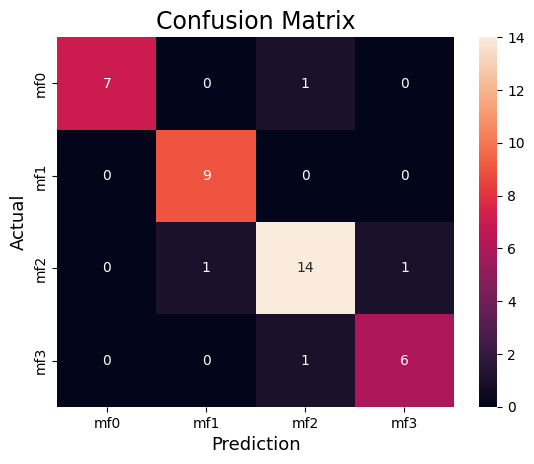

In [25]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)

# Calculate and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['mf0', 'mf1', 'mf2', 'mf3'], yticklabels=['mf0', 'mf1', 'mf2', 'mf3'])
plt.xlabel('Prediction', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.savefig('confusion_matrix_heatmap.png', bbox_inches='tight')  # Save as PNG file
plt.show()